In [27]:
# Langkah 1: Seleksi Data
import pandas as pd

# Baca dataset
df = pd.read_csv('dataset_tempat_wisata_bali.csv')

# Tampilkan 5 baris pertama
print("Contoh data:")
print(df.head())

# Informasi struktur dataset
print("\nInformasi dataset:")
print(df.info())

# Cek nilai unik per kolom
print("\nJumlah nilai unik per kolom:")
print(df.nunique())


Contoh data:
                     nama kategori    kabupaten_kota  rating   preferensi  \
0     Taman Mumbul Sangeh     Alam  Kabupaten Badung     4.6  Wisata Alam   
1    Sangeh Monkey Forest     Alam  Kabupaten Badung     4.6  Wisata Alam   
2     Objek Wisata Sangeh     Umum  Kabupaten Badung     4.6  Wisata Umum   
3   Satria Gatotkaca Park     Umum  Kabupaten Badung     4.6  Wisata Umum   
4  Desa Wisata Penarungan     Umum  Kabupaten Badung     5.0  Wisata Umum   

                                                link    latitude    longitude  
0  https://www.google.com/maps/place/Taman+Mumbul...   -8.483959  115.2122881  
1  https://www.google.com/maps/place/Sangeh+Monke...  -8.4817743  115.2067391  
2  https://www.google.com/maps/place/Objek+Wisata...  -8.4815663  115.2065458  
3  https://www.google.com/maps/place/Satria+Gatot...  -8.7443882  115.1788673  
4  https://www.google.com/maps/place/Desa+Wisata+...  -8.5396366   115.198893  

Informasi dataset:
<class 'pandas.core.fram

In [28]:
# Langkah 2: Preprocessing Data

# 1. Cek missing values
print("Jumlah missing values per kolom:")
print(df.isnull().sum())

# 2. Drop baris yang memiliki missing value pada kolom penting
# Kita butuh 'rating', 'latitude', dan 'longitude' untuk clustering
df_clean = df.dropna(subset=['rating', 'latitude', 'longitude'])

# 3. Reset index
df_clean = df_clean.reset_index(drop=True)

# 4. Pastikan data numerik sesuai
print("\nTipe data setelah dibersihkan:")
print(df_clean.dtypes)

# 5. Tampilkan dimensi data setelah dibersihkan
print("\nUkuran data setelah dibersihkan:", df_clean.shape)


Jumlah missing values per kolom:
nama               0
kategori           0
kabupaten_kota     0
rating            10
preferensi         0
link               0
latitude           0
longitude          0
dtype: int64

Tipe data setelah dibersihkan:
nama               object
kategori           object
kabupaten_kota     object
rating            float64
preferensi         object
link               object
latitude           object
longitude          object
dtype: object

Ukuran data setelah dibersihkan: (751, 8)


In [31]:
# Langkah 3 (Final Fix): Hapus titik sebagai pemisah ribuan

# Hapus semua titik di kolom koordinat
df_clean['latitude'] = df_clean['latitude'].str.replace('.', '', regex=False)
df_clean['longitude'] = df_clean['longitude'].str.replace('.', '', regex=False)

# Sisipkan titik desimal di posisi yang sesuai (misalnya setelah 2 digit pertama: -8671722 -> -8.671722)
df_clean['latitude'] = df_clean['latitude'].apply(lambda x: float(x[:3] + '.' + x[3:]) if '-' in x else float(x[:2] + '.' + x[2:]))
df_clean['longitude'] = df_clean['longitude'].apply(lambda x: float(x[:3] + '.' + x[3:]) if '-' in x else float(x[:3] + '.' + x[3:]))

# Cek hasil
print(df_clean[['latitude', 'longitude']].dtypes)
print(df_clean[['latitude', 'longitude']].head())


ValueError: could not convert string to float: '-8,.671,722'

In [30]:
# Ulangi: Hapus semua titik ribuan
df_clean['latitude'] = df_clean['latitude'].astype(str).str.replace('.', '', regex=False)
df_clean['longitude'] = df_clean['longitude'].astype(str).str.replace('.', '', regex=False)

# Sisipkan titik setelah 2 digit pertama (contoh: -8671722 -> -8.671722)
df_clean['latitude'] = df_clean['latitude'].apply(lambda x: float(x[:2] + '.' + x[2:]) if '-' in x else float(x[:2] + '.' + x[2:]))
df_clean['longitude'] = df_clean['longitude'].apply(lambda x: float(x[:3] + '.' + x[3:]))

# Cek kembali hasilnya
print(df_clean[['latitude', 'longitude']].head())


ValueError: could not convert string to float: '-8.,671,722'

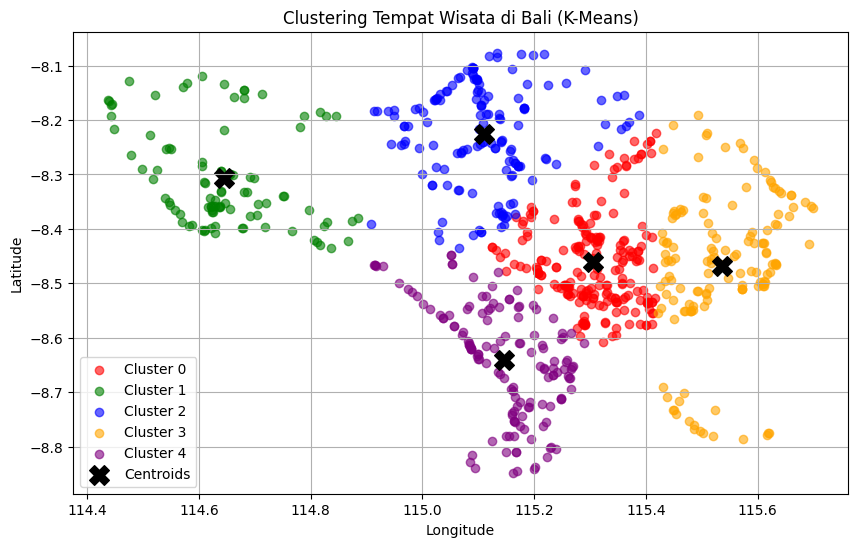

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Ambil fitur lokasi
X = df_clean[['latitude', 'longitude']]

# Inisialisasi dan fit KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X)

# Simpan pusat cluster
centroids = kmeans.cluster_centers_

# Visualisasi hasil clustering
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange', 'purple']

for i in range(5):
    cluster_data = df_clean[df_clean['cluster'] == i]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'],
                label=f'Cluster {i}', alpha=0.6, c=colors[i])

# Plot pusat cluster
plt.scatter(centroids[:, 1], centroids[:, 0], s=200, c='black', marker='X', label='Centroids')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering Tempat Wisata di Bali (K-Means)')
plt.legend()
plt.grid(True)
plt.show()


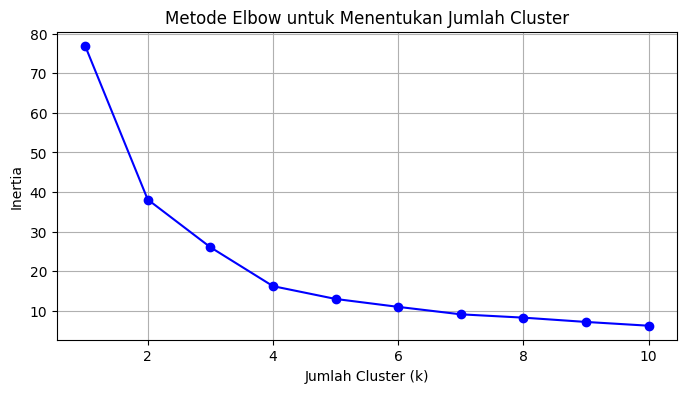

In [ ]:
# Evaluasi jumlah cluster optimal (optional step)
inertia = []
K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

# Visualisasi Elbow
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster')
plt.grid(True)
plt.show()


In [ ]:
import joblib

# Simpan model KMeans
joblib.dump(kmeans, 'model_kmeans.pkl')

# Simpan data hasil clustering
df_clean.to_csv('data_tempat_wisata_clustered.csv', index=False)
